In [11]:
import pickle5 as pickle
from PIL import Image
import json



with open("output/ours/frei/ori/pred_ori.json") as f:
    v = json.load(f)
    model1, gt_list = v[0], v[1]
    
    
with open("output/ours/frei/gcn/hrnet/loss/heatmap/add/gcn_0_0_1_layer_2/pred_gcn_0_0_1_layer_2.json") as f:
    model2 = json.load(f)[0]


In [14]:
import numpy as np
from scipy.linalg import orthogonal_procrustes

def align_w_scale(mtx1, mtx2, return_trafo=False):
    """ Align the predicted entity in some optimality sense with the ground truth. """
    mtx1, mtx2 = np.array(mtx1), np.array(mtx2)
    # center
    t1 = mtx1.mean(0)
    t2 = mtx2.mean(0)
    mtx1_t = mtx1 - t1
    mtx2_t = mtx2 - t2

    # scale
    s1 = np.linalg.norm(mtx1_t) + 1e-8
    mtx1_t /= s1
    s2 = np.linalg.norm(mtx2_t) + 1e-8
    mtx2_t /= s2

    # orth alignment
    R, s = orthogonal_procrustes(mtx1_t, mtx2_t)

    # apply trafos to the second matrix
    mtx2_t = np.dot(mtx2_t, R.T) * s
    mtx2_t = mtx2_t * s1 + t1
    return mtx2_t

## 정답 => 검은색
## Ori => 빨간색
## Gcn => 초록색

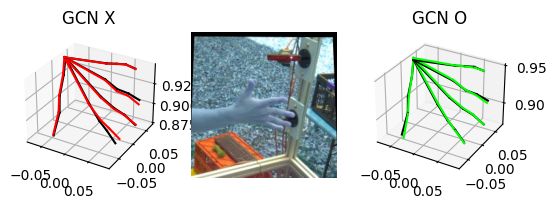

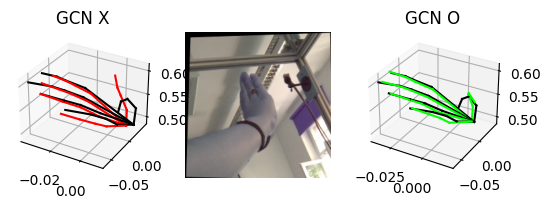

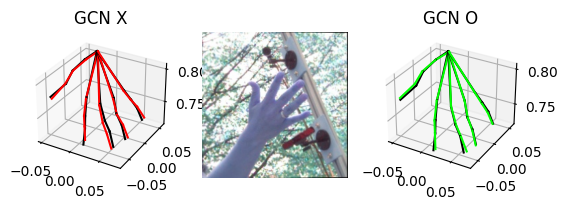

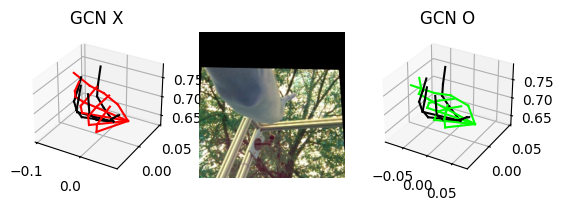

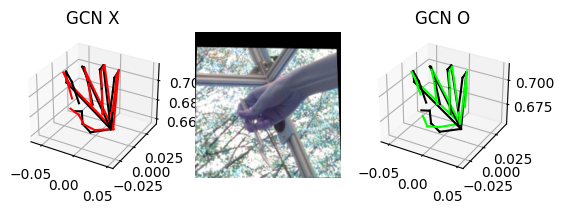

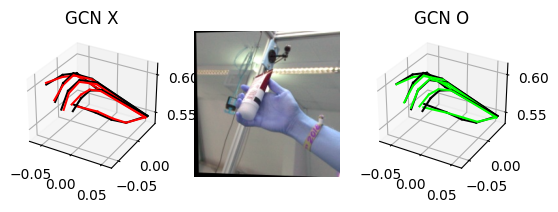

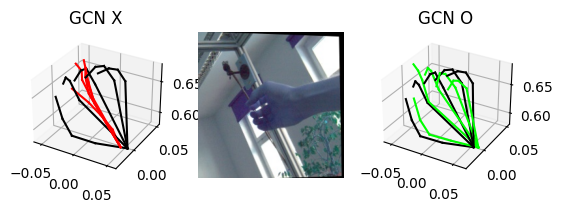

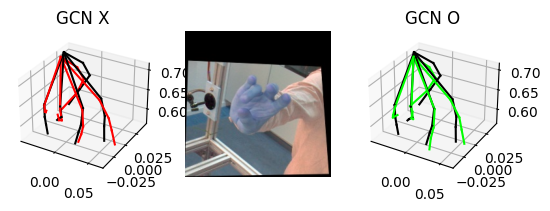

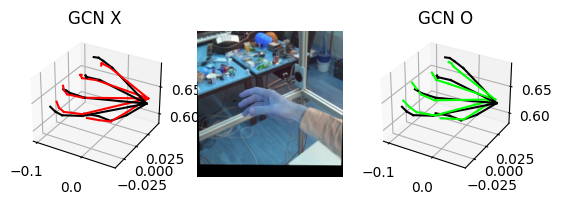

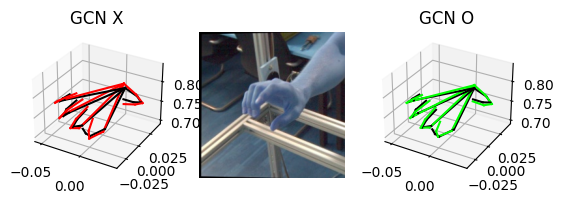

In [21]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
import cv2



for idx in range(10):
    gt = gt_list[idx]
    pred1 = model1[idx]
    pred2 = model2[idx]
    
    pred1 = align_w_scale(gt, pred1)
    pred2 = align_w_scale(gt, pred2)
    
    fig = plt.figure(dpi= 100)
    ax1 = fig.add_subplot(131, projection ='3d')
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133, projection ='3d')
    parents = [-1, 0, 1, 2, 3, 0, 5, 6, 7, 0, 9, 10, 11, 0, 13, 14, 15, 0, 17, 18, 19]

    for num in range(1, 21):
        
        ax1.plot([gt[num][0], gt[parents[num]][0]], [gt[num][1], gt[parents[num]][1]], [gt[num][2], gt[parents[num]][2]], c = np.array((0, 0, 0))/255.)
        ax1.plot([pred1[num][0], pred1[parents[num]][0]], [pred1[num][1], pred1[parents[num]][1]], [pred1[num][2], pred1[parents[num]][2]], c = np.array((255, 0, 0))/255.)
        ax3.plot([gt[num][0], gt[parents[num]][0]], [gt[num][1], gt[parents[num]][1]], [gt[num][2], gt[parents[num]][2]], c = np.array((0, 0, 0))/255.)
        ax3.plot([pred2[num][0], pred2[parents[num]][0]], [pred2[num][1], pred2[parents[num]][1]], [pred2[num][2], pred2[parents[num]][2]], c = np.array((0, 255, 0))/255.)
        
    img = cv2.imread(f'../../datasets/frei_test/evaluation/rgb/{str(idx).zfill(8)}.jpg')
    ax2.imshow(img)

    ax1.set_title("GCN X")
    ax3.set_title("GCN O")
    ax2.set_axis_off()
    
    # ax1.set_xlabel("X")
    # ax1.set_ylabel("Y")
    
    plt.show()

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

for idx in range(10):
    joint_3d = meta[f'{idx}']['world_coord'][:21]
    fig = plt.figure(dpi= 100)
    ax1 = fig.add_subplot(131, projection ='3d')
    parents = [-1, 0, 1, 2, 3, 0, 5, 6, 7, 0, 9, 10, 11, 0, 13, 14, 15, 0, 17, 18, 19]
    
    for num in range(1,21):
        # ax1.scatter(joint_3d[num][0], joint_3d[num][1], joint_3d[num][2], c = 'blue')
        ax1.plot([joint_3d[num][0], joint_3d[parents[num]][0]], [joint_3d[num][1], joint_3d[parents[num]][1]], [joint_3d[num][2], joint_3d[parents[num]][2]], c = np.array((0, 0, 0))/255.)
        
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_title("Z")
    plt.show()


NameError: name 'meta' is not defined